# Polynomial Regression simulation

Accompaniment to Lecture 3

In this document, I'll be doing everything very by-hand. If you were normally to estimate these models, you would usually want to use Scikit-learn's wrappers. This is all pedagogical to reinforce the math, so I'm sticking very close to the math I've shown you in the lectures.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting a random seed lets us exactly replicate our results from one run to another.
np.random.seed(333)

# The Data

Define a probabilistic model for data which we will collect.

$$ x \sim \mathrm{Exp}(1)\\

\mathbb{E}[y\mid x] = \mu(x) = 6\sin(3x) \cdot \exp\{-x^2\}\\

\epsilon \sim \mathrm{Norm}(0,1)\\

y = \mu(x) + \epsilon
$$

We can implement this in code as follows:

In [2]:
def dgp(n):
    x = np.sort(np.random.normal(size = (n,)))
    mu = 6 * np.sin(3 * x) * np.exp(- np.power(x, 2))
    y = mu + np.random.normal(size = (n,))
    return x, y

def true(n):
    x = np.linspace(-3, 3, num = n)
    return x, 6 * np.sin(3 * x) * np.exp(-np.power(x, 2))

In [3]:
x, y = dgp(n = 250)
x_true, y_true = true(1000)

# Plot data

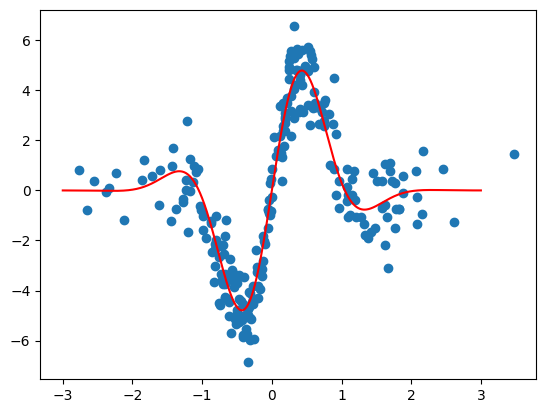

In [4]:
plt.scatter(x, y)
plt.plot(x_true, y_true, '-', color='red');

# Create a feature matrix

This creates a feature matrix in the most naïve way possible: simply calculating polynomials directly.

In [5]:
def create_feature_matrix(x, degree=5):
    n = x.shape[0]
    X = None
    for k in range(1, degree + 1):
        if X is not None:
            X = np.hstack((X, np.power(x, k).reshape(-1, 1)))
        else:
            X = np.power(x, k).reshape(-1, 1)
    return np.hstack((np.ones((n, 1)), X))

# Fit simple model
Now it's easy to calculate the optimal coefficients using linear regression for our simple degree-2 model.

In [6]:
X = create_feature_matrix(x, degree = 2)
beta_inv_small = np.linalg.inv(X.T @ X) @ X.T @ y
yhat_small = X @ beta_inv_small

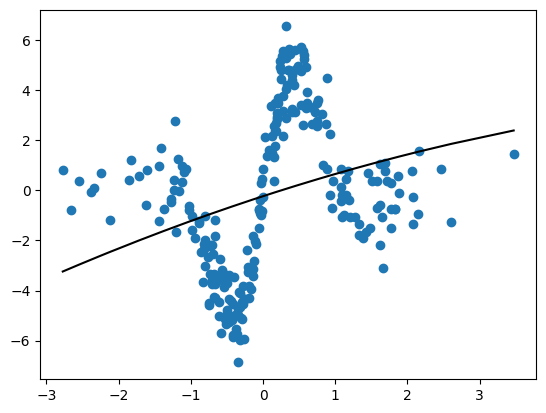

In [7]:
plt.scatter(x, y)
plt.plot(x, yhat_small, '-', color='black');

So this model doesn't look very good. What do our errors look like? Do they look like there's systematic bias at any values of x?

We can check this out with a residual plot.

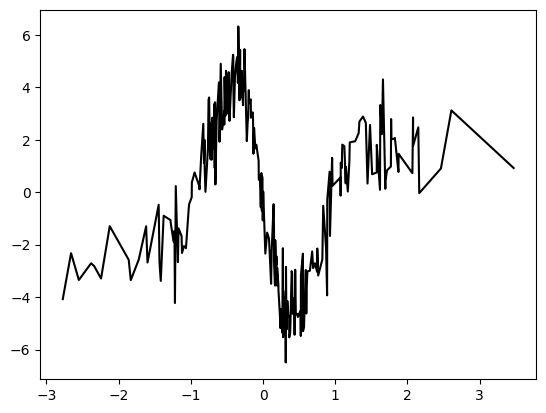

In [8]:
plt.plot(x, yhat_small - y, '-', color='black');

# Predicted-residual plot

This scales better when we're doing more than polynomial modelling of a single underlying feature!

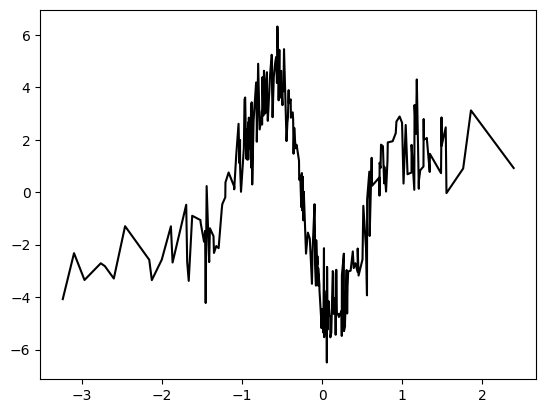

In [9]:
plt.plot(yhat_small, yhat_small - y, '-', color='black');

# Fit larger model

We can also fit a degree 10 model:

In [10]:
X = create_feature_matrix(x, degree = 10)
beta_inv_large = np.linalg.inv(X.T @ X) @ X.T @ y
yhat_large = X @ beta_inv_large

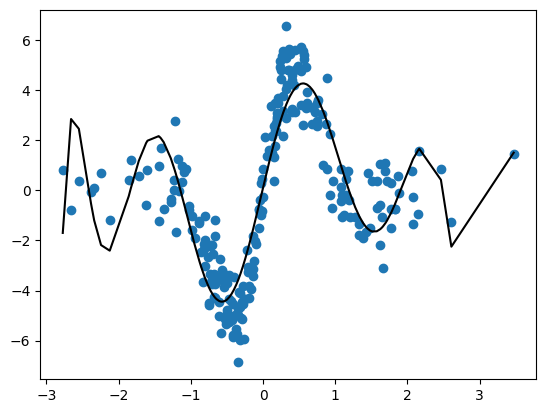

In [11]:
plt.scatter(x, y)
plt.plot(x, yhat_large, '-', color='black');

# Fit huge model

What about when we fit a huge model with a degree 100 polynomial?

In [12]:
X = create_feature_matrix(x, degree = 100)
beta_inv_huge = np.linalg.inv(X.T @ X) @ X.T @ y
yhat_huge = X @ beta_inv_huge

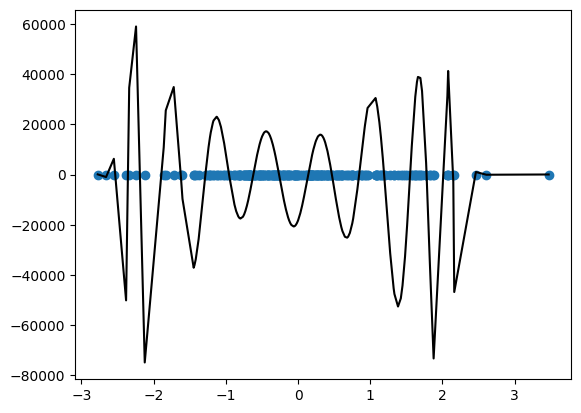

In [13]:
plt.scatter(x, y)
plt.plot(x, yhat_huge, '-', color='black');

That looks extremely bad, what's going on?

In [14]:
X = create_feature_matrix(x, degree = 5)
np.corrcoef(X.T[1:,1:])

array([[1.        , 0.21310855, 0.77306836, 0.19819009, 0.5084566 ],
       [0.21310855, 1.        , 0.31941382, 0.87217874, 0.38386658],
       [0.77306836, 0.31941382, 1.        , 0.45818669, 0.90382602],
       [0.19819009, 0.87217874, 0.45818669, 1.        , 0.64407695],
       [0.5084566 , 0.38386658, 0.90382602, 0.64407695, 1.        ]])

Features are very highly correlated with one another. We can also check whether we're likely to have numerical errors with the condition number:

In [15]:
np.linalg.cond(X.T @ X)

11202.4409638545

In [16]:
X = create_feature_matrix(x, degree = 100)
np.linalg.cond(X.T @ X)

6.0032199256875365e+88

These are absurdly large condition numbers which means that our solutions will be very error-prone. Our next step is to use an improved feature representation for polynomials with the same representational power, but which isn't so prone to numerical instability.

# Orthogonal feature representations

You don't need to understand the details here, but if you're interested, you can read some more here: https://davmre.github.io/blog/python/2013/12/15/orthogonal_poly

In [17]:
import numpy as np

def ortho_poly_fit(x, degree = 1):
    n = degree + 1
    x = np.asarray(x).flatten()
    if(degree >= len(np.unique(x))):
            raise ValueError("'degree' must be less than number of unique points")
    xbar = np.mean(x)
    x = x - xbar
    X = np.fliplr(np.vander(x, n))
    q,r = np.linalg.qr(X)

    z = np.diag(np.diag(r))
    raw = np.dot(q, z)

    norm2 = np.sum(raw**2, axis=0)
    alpha = (np.sum((raw**2)*np.reshape(x,(-1,1)), axis=0)/norm2 + xbar)[:degree]
    Z = raw / np.sqrt(norm2)
    return Z, np.concatenate(([1],norm2)), alpha

def ortho_poly_predict(x, norm2, alpha, degree = 1):
    x = np.asarray(x).flatten()
    n = degree + 1
    Z = np.ones((len(x), n))
    Z[:, 1] = x - alpha[0]
    if degree > 1:
      for i in np.arange(1,degree):
          Z[:, i+1] = (x - alpha[i]) * Z[:, i] - (norm2[i+1] / norm2[i]) * Z[:, i-1]
    Z /= np.sqrt(norm2[1:])
    return Z

In [18]:
X, _, _ = ortho_poly_fit(x, degree = 5)
np.corrcoef(X.T[1:,1:])

array([[ 1.        ,  0.05588037, -0.05883008,  0.05953683, -0.06692714],
       [ 0.05588037,  1.        ,  0.10153871, -0.10275853,  0.11551395],
       [-0.05883008,  0.10153871,  1.        ,  0.10818276, -0.1216115 ],
       [ 0.05953683, -0.10275853,  0.10818276,  1.        ,  0.12307246],
       [-0.06692714,  0.11551395, -0.1216115 ,  0.12307246,  1.        ]])

In [19]:
np.linalg.cond(X.T @ X)

1.000000000000001

So after this process, we get much more stable estimates. We can even go ahead and re-estimate that "huge" model of degree 100 now:

In [20]:
X, norm2, alpha = ortho_poly_fit(x, degree = 100)
beta_huge_stable = np.linalg.inv(X.T @ X) @ X.T @ y
yhat_huge_stable = X @ beta_huge_stable

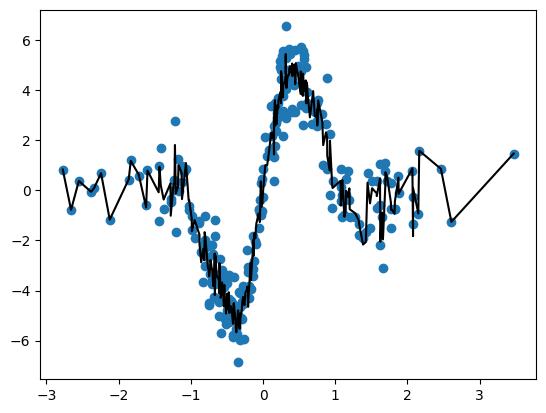

In [21]:
plt.scatter(x, y)
plt.plot(x, yhat_huge_stable, '-', color='black');

# Evaluation

To get a sense of how well this model performs, we need data from outside the sample. Since we're generating the data in this case, we'll just draw an independent set of samples from that process we've already defined.

In [22]:
x_test, y_test = dgp(n = 1000)

Loop over all of the degrees we want to test and record our test-set MSE at each point.

In [23]:
mse = {}
mse_se = {}
degrees_to_test = np.concatenate((np.arange(1, 10, 1), np.arange(10, 100, step = 5)))
for k in degrees_to_test:
    X, norm2, alpha = ortho_poly_fit(x, degree = k)
    X_test = ortho_poly_predict(x_test, norm2, alpha, degree = k)
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    y_hat = X_test @ beta_hat
    mse[k] = np.average(np.power(y_hat - y_test, 2))
    mse_se[k] = np.std(np.power(y_hat - y_test, 2)) / np.sqrt(len(y_test))

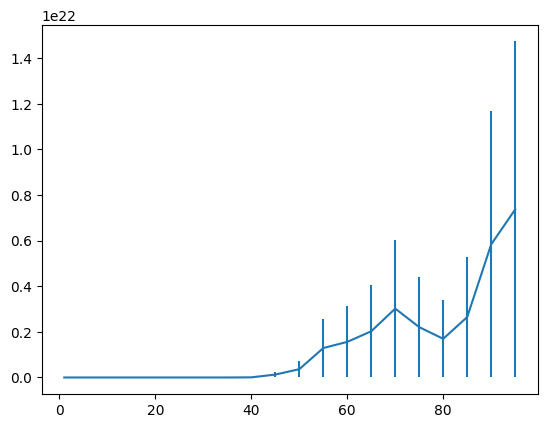

In [24]:
plt.errorbar(degrees_to_test, list(mse.values()), yerr=list(mse_se.values()));

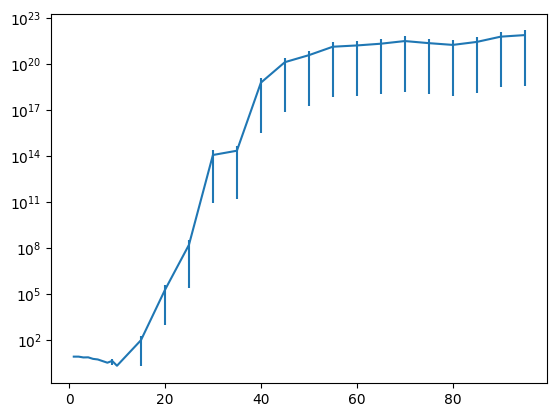

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(degrees_to_test, list(mse.values()), yerr=list(mse_se.values()))
ax.set_yscale('log')

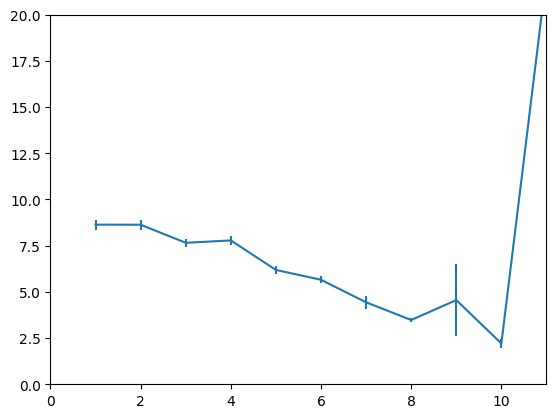

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(degrees_to_test, list(mse.values()), yerr=list(mse_se.values()))
ax.set_xlim(0, 11)
ax.set_ylim(0, 20);

So we can see that models with degree between 7 and 10 tend to be doing a good job.

First, let's see what the 100-degree model looks like:

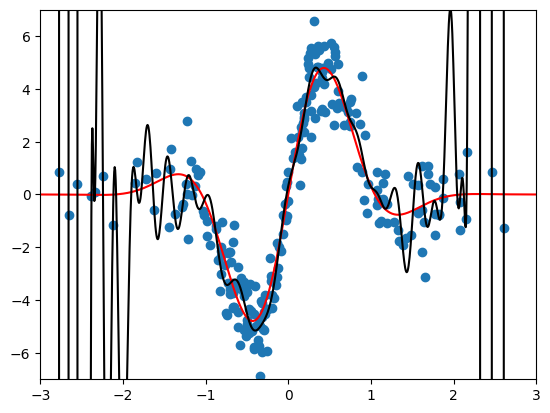

In [27]:
X, norm2, alpha = ortho_poly_fit(x, degree = 100)
X_true = ortho_poly_predict(x_true, norm2, alpha, degree = 100)
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
y_hat = X_true @ beta_hat

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, y)
ax.plot(x_true, y_true, '-', color='red')
ax.plot(x_true, y_hat, '-', color='black')
ax.set_xlim(-3, 3)
ax.set_ylim(-7, 7);

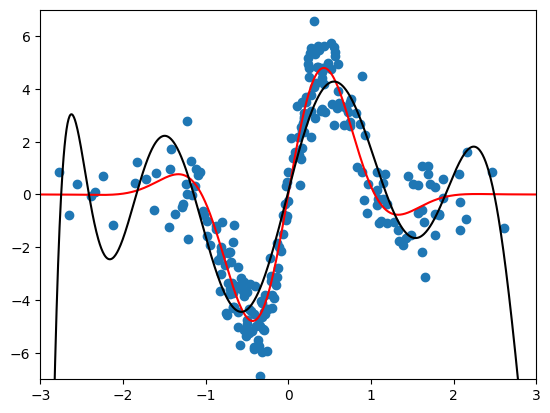

In [28]:
X, norm2, alpha = ortho_poly_fit(x, degree = 10)
X_true = ortho_poly_predict(x_true, norm2, alpha, degree = 10)
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
y_hat = X_true @ beta_hat

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, y)
ax.plot(x_true, y_true, '-', color='red')
ax.plot(x_true, y_hat, '-', color='black')
ax.set_xlim(-3, 3)
ax.set_ylim(-7, 7);

# Regularization

Now let's think about incorporating regularization!

In [29]:
results = []
degrees_to_test = np.concatenate((np.arange(1, 10, 1), np.arange(10, 100, step = 5)))
for k in degrees_to_test:
    for l in np.logspace(-20, 10, num = 250):
        X, norm2, alpha = ortho_poly_fit(x, degree = k)
        X_test = ortho_poly_predict(x_test, norm2, alpha, degree = k)
        beta_hat = np.linalg.inv(X.T @ X + np.eye(k + 1) * l) @ X.T @ y
        y_hat = X_test @ beta_hat
        this_result = {}
        this_result["k"] = k
        this_result["l"] = l
        this_result["mse"] = np.average(np.power(y_hat - y_test, 2))
        this_result["mse_se"] = np.std(np.power(y_hat - y_test, 2)) / np.sqrt(len(y_test))
        results.append(this_result)

result_df = pd.DataFrame.from_records(results)

In [30]:
result_df.loc[result_df["k"] == 6].head(20)

,k,l,mse,mse_se
1250,6,1.000000e-20,5.654361,0.187947
1251,6,1.319720e-20,5.654361,0.187947
1252,6,1.741662e-20,5.654361,0.187947
1253,6,2.298507e-20,5.654361,0.187947
1254,6,3.033386e-20,5.654361,0.187947
1255,6,4.003222e-20,5.654361,0.187947
1256,6,5.283133e-20,5.654361,0.187947
1257,6,6.972259e-20,5.654361,0.187947
1258,6,9.201432e-20,5.654361,0.187947
1259,6,1.214332e-19,5.654361,0.187947


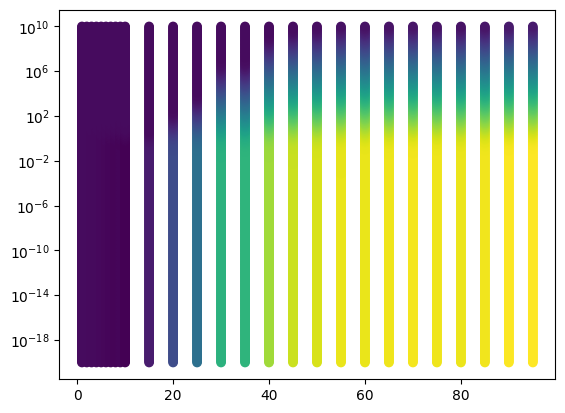

In [31]:
#tbl = result_df.pivot_table(index = "k", columns = "l", values = "mse", aggfunc = "mean").sort_index(ascending=False)
from matplotlib.colors import LogNorm

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
scatter = ax.scatter(result_df["k"].values, result_df["l"].values, c = result_df["mse"].values, norm=LogNorm(), cmap="viridis")
ax.set_yscale('log')

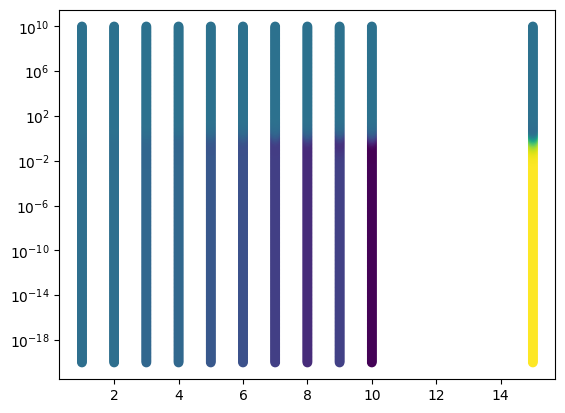

In [32]:
slice_df = result_df.loc[result_df["k"] <= 15]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
scatter = ax.scatter(slice_df["k"].values, slice_df["l"].values, c = slice_df["mse"].values, norm=LogNorm(), cmap="viridis")
ax.set_yscale('log')

In [33]:
opt_for_k = result_df.groupby('k').mse.transform("min")
#result_df.groupby(by=["k"]).apply(lambda g: g["mse"] == g["mse"].min())
slice_df = result_df[result_df.mse == opt_for_k]
slice_df.head(10)

,k,l,mse,mse_se
162,1,0.329665,8.586973,0.285577
412,2,0.329665,8.579819,0.284138
659,3,0.143426,7.622409,0.236454
912,4,0.329665,7.567420,0.233801
1160,5,0.189282,6.068021,0.195245
1410,6,0.189282,5.540459,0.177579
1660,7,0.189282,4.281400,0.261383
1908,8,0.108679,3.426646,0.125547
2163,9,0.435065,3.766252,0.942307
2407,10,0.082350,2.162560,0.201690


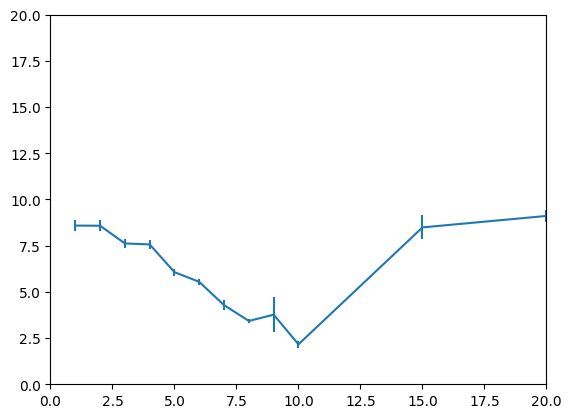

In [34]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(slice_df["k"], slice_df["mse"], yerr=slice_df["mse_se"])
ax.set_xlim(0, 20)
ax.set_ylim(0, 20);

       k        l      mse   mse_se
2407  10  0.08235  2.16256  0.20169


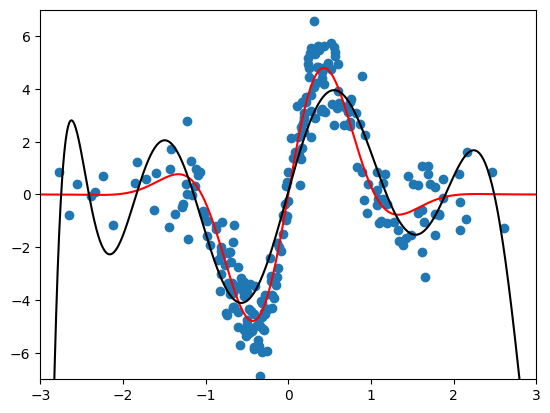

In [35]:
opt = slice_df[slice_df["mse"] == slice_df["mse"].min()]
print(opt)


X, norm2, alpha = ortho_poly_fit(x, degree = opt["k"].item())
X_true = ortho_poly_predict(x_true, norm2, alpha, degree = opt["k"].item())
beta_hat = np.linalg.inv(X.T @ X + np.eye(opt["k"].item() + 1) * opt["l"].item()) @ X.T @ y
y_hat = X_true @ beta_hat

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, y)
ax.plot(x_true, y_true, '-', color='red')
ax.plot(x_true, y_hat, '-', color='black')
ax.set_xlim(-3, 3)
ax.set_ylim(-7, 7);